Found 1193 files belonging to 1 classes.


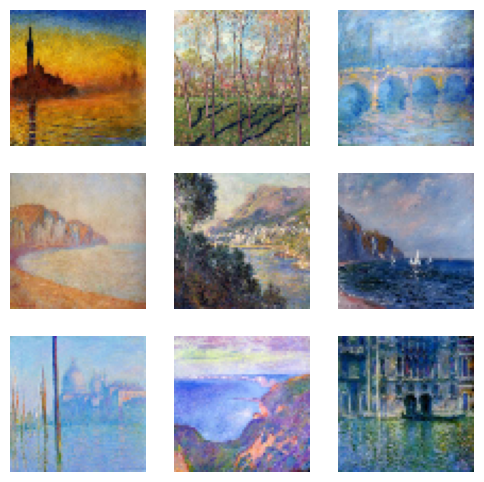

In [8]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

# Define dataset parameters
IMG_SIZE = 64  # Standard for DCGAN
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Function to load and preprocess dataset
def load_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        label_mode=None,  # No labels required
        image_size=(IMG_SIZE, IMG_SIZE),  # Resize images correctly
        batch_size=None  # Do not batch here!
    )

    # Resize and normalize images manually
    dataset = dataset.map(lambda x: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)) / 127.5) - 1.0)

    # Batch after resizing
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    return dataset

# Load dataset
dataset_path = "images"  # Update path if needed
dataset = load_dataset(dataset_path)

# Visualize some images
plt.figure(figsize=(6,6))
for images in dataset.take(1):
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow((images[i].numpy() + 1) / 2)  # Convert back to [0,1] range
        plt.axis('off')
plt.show()


In [9]:
import tensorflow as tf
from tensorflow.keras import layers

# Define Generator Model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),  # Fully connected layer
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),  # Reshape to 8x8x256

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

    return model

# Create generator
generator = build_generator()
generator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 128)      

In [10]:
# Define Discriminator Model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Create discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)            

In [11]:
# Define GAN Model
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

    discriminator.trainable = False  # Freeze discriminator when training GAN
    gan_input = tf.keras.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

    return gan

# Create GAN
gan = build_gan(generator, discriminator)
gan.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         2733504   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 242561    
                                                                 
Total params: 2976065 (11.35 MB)
Trainable params: 2700352 (10.30 MB)
Non-trainable params: 275713 (1.05 MB)
_________________________________________________________________


Epoch 0: D Loss = 0.3759, G Loss = 1.1275


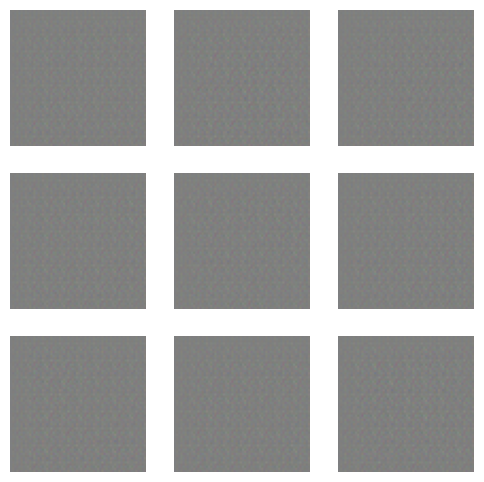

In [ ]:
import numpy as np
import time
from IPython.display import display, clear_output

EPOCHS = 500  # Adjust based on need
BATCH_SIZE = 64
NOISE_DIM = 100

# Training function
def train_gan(dataset, epochs):
    for epoch in range(epochs):
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Generate fake images
            noise = tf.random.normal([batch_size, NOISE_DIM])
            fake_images = generator(noise, training=True)

            # Create labels for real (1) and fake (0)
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train generator (via GAN model)
            noise = tf.random.normal([batch_size, NOISE_DIM])
            g_loss = gan.train_on_batch(noise, tf.ones((batch_size, 1)))  # Wants to fool discriminator

        # Display progress
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss:.4f}, G Loss = {g_loss:.4f}")
            generate_and_save_images(generator, epoch, NOISE_DIM)

# Function to visualize generated images
def generate_and_save_images(model, epoch, noise_dim):
    noise = tf.random.normal([9, noise_dim])
    generated_images = model(noise, training=False)
    
    generated_images = (generated_images + 1) / 2  # Convert back to [0,1] range
    
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')
    
    plt.show()
    
# Train the GAN
train_gan(dataset, EPOCHS)


In [ ]:
# Generate new images after training
noise = tf.random.normal([9, 100])
generated_images = generator(noise, training=False)

# Display generated images
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((generated_images[i].numpy() + 1) / 2)
    plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("GAN Training Loss")
    plt.show()

# Assuming we stored losses in lists:
plot_loss(d_losses, g_losses)


In [ ]:
# Generate and display images
def generate_images(model, num_images=9):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False)

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = (generated_images[i].numpy() + 1) / 2  # Convert from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis('off')
    
    plt.show()

generate_images(generator)


In [ ]:
generator.save("dcgan_generator.h5")
print("Generator Model Saved!")


In [ ]:
from tensorflow.keras.models import load_model

# Load trained generator
saved_generator = load_model("dcgan_generator.h5")

# Generate images with the saved model
generate_images(saved_generator)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.stats import entropy
import numpy as np

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg')

def calculate_inception_score(images, n_splits=10):
    preds = inception_model.predict(images)
    scores = []
    
    for i in np.array_split(preds, n_splits):
        p_yx = np.exp(i) / np.sum(np.exp(i), axis=1, keepdims=True)  # Softmax
        p_y = np.mean(p_yx, axis=0)  # Marginal distribution
        scores.append(np.exp(entropy(p_yx.T, p_y)))  # KL divergence

    return np.mean(scores), np.std(scores)

# Generate images
num_images = 100
noise = tf.random.normal([num_images, 100])
generated_images = generator(noise, training=False)

# Normalize images
generated_images = (generated_images + 1) / 2

# Compute IS
is_mean, is_std = calculate_inception_score(generated_images)
print(f"Inception Score: {is_mean} ± {is_std}")


In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

def calculate_fid(real_images, fake_images):
    real_images = preprocess_input(real_images)
    fake_images = preprocess_input(fake_images)

    # Get features from InceptionV3
    real_features = inception_model.predict(real_images)
    fake_features = inception_model.predict(fake_images)

    # Calculate mean and covariance
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Compute Fréchet Distance
    ssdiff = np.sum((mu_real - mu_fake) ** 2)
    covmean = sqrtm(sigma_real @ sigma_fake)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Use real dataset images and generated images
real_images = next(iter(dataset.take(1)))[0].numpy()
fid_score = calculate_fid(real_images, generated_images)

print(f"FID Score: {fid_score}")


In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(real_images, fake_images):
    scores = []
    for i in range(len(real_images)):
        score = ssim(real_images[i], fake_images[i], multichannel=True)
        scores.append(score)
    return np.mean(scores)

ssim_score = calculate_ssim(real_images, generated_images)
print(f"SSIM Score: {ssim_score}")
